# P60 Gitterschwingungen in Festkörpern

### Import libaries

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import seaborn as sns

from matplotlib.ticker import FuncFormatter
from matplotlib.colors import TABLEAU_COLORS, same_color
from scipy.optimize import curve_fit
from scipy.stats import linregress
from numpy import sqrt


%matplotlib inline

### Set sytle parameters

In [ ]:

#plt.style.available[:30]

plt.style.use('default')
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.default'] = 'regular'


### Get and set colors

In [ ]:
# Get the color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

print(colors)


# Si (100) determine x- and y-axis

### Import data

In [ ]:
file_path_si100_parallel = r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Messwerte\si100 polarisation 0grad\\'
file_path_si100_perpendicular = r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Messwerte\si100 polarisation 90grad\\'


file_names = ['si100_0grad.txt', 'si100_15grad.txt', 'si100_30grad.txt', 'si100_45grad.txt', 
              'si100_60grad.txt', 'si100_75grad.txt', 'si100_90grad.txt',
              'si100_105grad.txt', 'si100_120grad.txt', 'si100_135grad.txt', 
              'si100_150grad.txt', 'si100_165grad.txt', 'si100_180grad.txt']

dataframes_si100_parallel = []
dataframes_si100_perpendicular = []


for file in file_names:
    df = pd.read_csv(file_path_si100_parallel + file, sep=r'\s+', names=['Wavenumber', 'Intensity'])
    dataframes_si100_parallel.append(df)

    
for file in file_names:
    df = pd.read_csv(file_path_si100_perpendicular + file, sep=r'\s+', names=['Wavenumber', 'Intensity'])
    dataframes_si100_perpendicular.append(df)


dataframes_si100_perpendicular[0].head()

### Plotting the data of Si (100)

In [ ]:
%matplotlib inline

norm_si100_parallel=1

fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)

ax.plot(dataframes_si100_parallel[0]['Wavenumber'], dataframes_si100_parallel[0]['Intensity']/norm_si100_parallel, label = '0°')
ax.plot(dataframes_si100_parallel[1]['Wavenumber'], dataframes_si100_parallel[1]['Intensity']/norm_si100_parallel, label = '15°')
ax.plot(dataframes_si100_parallel[2]['Wavenumber'], dataframes_si100_parallel[2]['Intensity']/norm_si100_parallel, label = '30°')
ax.plot(dataframes_si100_parallel[3]['Wavenumber'], dataframes_si100_parallel[3]['Intensity']/norm_si100_parallel, label = '45°')
ax.plot(dataframes_si100_parallel[4]['Wavenumber'], dataframes_si100_parallel[4]['Intensity']/norm_si100_parallel, label = '60°')
ax.plot(dataframes_si100_parallel[5]['Wavenumber'], dataframes_si100_parallel[5]['Intensity']/norm_si100_parallel, label = '75°')
ax.plot(dataframes_si100_parallel[6]['Wavenumber'], dataframes_si100_parallel[6]['Intensity']/norm_si100_parallel, label = '90°')
ax.plot(dataframes_si100_parallel[7]['Wavenumber'], dataframes_si100_parallel[7]['Intensity']/norm_si100_parallel, label = '105°')
ax.plot(dataframes_si100_parallel[8]['Wavenumber'], dataframes_si100_parallel[8]['Intensity']/norm_si100_parallel, label = '120°')
ax.plot(dataframes_si100_parallel[9]['Wavenumber'], dataframes_si100_parallel[9]['Intensity']/norm_si100_parallel, label = '135°')
ax.plot(dataframes_si100_parallel[10]['Wavenumber'], dataframes_si100_parallel[10]['Intensity']/norm_si100_parallel, label = '150°')
ax.plot(dataframes_si100_parallel[11]['Wavenumber'], dataframes_si100_parallel[11]['Intensity']/norm_si100_parallel, label = '165°')
ax.plot(dataframes_si100_parallel[12]['Wavenumber'], dataframes_si100_parallel[12]['Intensity']/norm_si100_parallel, label = '180°')

ax.set_xlabel(r'Wellenzahl ($cm^{-1}$)', fontsize = 14)
ax.set_ylabel('Intensität (counts)', fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=12)

#ax.set_xlim(500,540)
ax.legend(fontsize=14)


### Define Lorentzian Functions and FWHM

In [ ]:
# Lorentz function
def lorentzian(x, x0, gamma, a):
    return a * gamma**2 / ((x - x0)**2 + gamma**2)

# Calculate Full Width at Half Maximum (FWHM) for Lorentzian
def lorentzian_fwhm(gamma):
    return 2 * gamma

# double Lorentzian function
def double_lorentzian(x, x01, gamma1, a1, x02, gamma2, a2):
    L1 = a1 * (gamma1**2 / ((x - x01)**2 + gamma1**2))
    L2 = a2 * (gamma2**2 / ((x - x02)**2 + gamma2**2))
    return L1 + L2

# sum of 3 lorentzians
def three_lorentzian(x, x01, gamma1, a1, x02, gamma2, a2, x03, gamma3, a3):
    L1 = a1 * (gamma1**2 / ((x - x01)**2 + gamma1**2))
    L2 = a2 * (gamma2**2 / ((x - x02)**2 + gamma2**2))
    L3 = a3 * (gamma3**2 / ((x - x03)**2 + gamma3**2))
    return L1 + L2 + L3


# sum of 4 lorentzians
def four_lorentzian(x, x01, gamma1, a1, x02, gamma2, a2, x03, gamma3, a3, x04, gamma4, a4):
    L1 = a1 * (gamma1**2 / ((x - x01)**2 + gamma1**2))
    L2 = a2 * (gamma2**2 / ((x - x02)**2 + gamma2**2))
    L3 = a3 * (gamma3**2 / ((x - x03)**2 + gamma3**2))
    L4 = a4 * (gamma4**2 / ((x - x04)**2 + gamma4**2))
    return L1 + L2 + L3 + L4


# sum of 5 lorentzians
def five_lorentzian(x, x01, gamma1, a1, x02, gamma2, a2, x03, gamma3, a3, x04, gamma4, a4, x05, gamma5, a5):
    L1 = a1 * (gamma1**2 / ((x - x01)**2 + gamma1**2))
    L2 = a2 * (gamma2**2 / ((x - x02)**2 + gamma2**2))
    L3 = a3 * (gamma3**2 / ((x - x03)**2 + gamma3**2))
    L4 = a4 * (gamma4**2 / ((x - x04)**2 + gamma4**2))
    L5 = a5 * (gamma5**2 / ((x - x05)**2 + gamma5**2))
    return L1 + L2 + L3 + L4 + L5


# Fitting Lorentzian to data in specific range
def n_lorentzians_fit (df, function, xmin, xmax, p0):
    df_region = (df['Wavenumber'] > xmin) & (df['Wavenumber'] < xmax)
    xdata = df['Wavenumber'][df_region]
    ydata = df['Intensity'][df_region]
    params, cov = curve_fit(function, xdata, ydata, p0)
    perr = np.sqrt(np.diag(cov))

    return xdata, params, perr

### Testing some stuff

In [ ]:
%matplotlib inline

dfv = 2

# Define linespace for better lorentzian fit
x = np.linspace(-20, 1200, 2440)

# Select rayleigh peak region to find amplitude for inital guess
rayleigh_peak_region = (dataframes_si100_parallel[dfv]['Wavenumber'] > -14) & (dataframes_si100_parallel[dfv]['Wavenumber'] < 4)
rayleigh_amplitude = dataframes_si100_parallel[dfv]['Intensity'][rayleigh_peak_region].max()

# Antistokes peak region
antistokes_peak_region = (dataframes_si100_parallel[dfv]['Wavenumber'] > 505) & (dataframes_si100_parallel[dfv]['Wavenumber'] < 530)


# Initial guess: [center, width, amplitude]
p0 = [-4, 5, rayleigh_amplitude]

# Fit
x_data = dataframes_si100_parallel[dfv]['Wavenumber']
y_data = dataframes_si100_parallel[dfv]['Intensity']

params, cov = curve_fit(lorentzian, x_data, y_data, p0=p0, maxfev=10000)
params_as_par, cov_as_par = curve_fit(lorentzian, x_data[antistokes_peak_region], y_data[antistokes_peak_region])
params_as_per, cov_as_per = curve_fit(lorentzian, dataframes_si100_perpendicular[dfv]['Wavenumber'][antistokes_peak_region], dataframes_si100_perpendicular[dfv]['Intensity'][antistokes_peak_region])


# Example usage with fitted gamma parameter
fwhm = lorentzian_fwhm(params[1])
print(f"Full Width at Half Maximum (FWHM): {fwhm:.2f}")


# Plot fit
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)


ax.plot(x_data, y_data, label='Data', marker='o', ls='', ms=3)
ax.plot(dataframes_si100_perpendicular[dfv]['Wavenumber'], dataframes_si100_perpendicular[dfv]['Intensity'], 
        label='senkrecht', marker='o', ms=3, ls='')

#ax.plot(x, lorentzian(x, *params), label='Lorentz Fit', linestyle='--')
ax.plot(x, lorentzian(x, *params_as_par))
ax.plot(x, lorentzian(x, *params_as_per))


ax.set_xlabel(r'Wellenzahl ($cm^{-1}$)')
ax.set_ylabel('Intensität (counts)')
ax.legend()


print("Fit parameters: x0 = {:.2f}, gamma = {:.2f}, a = {:.2f}".format(*params))



### Fitting Anti-Stokes and Normilize Intensities of Si (100) parallel

In [ ]:
Lorentzian_amplitudes = []
Lorentzian_amplitudes_error = []

for i in range(13):

    # Region and amplitude for inital fit
    antistokes_peak_region = (dataframes_si100_parallel[i]['Wavenumber'] > 505) & (dataframes_si100_parallel[i]['Wavenumber'] < 530)
    antistokes_amplitude = dataframes_si100_parallel[i]['Intensity'][antistokes_peak_region].max()

    # Initial guess [center, width, amplitude]
    p0_antistokes = [517, 5 , antistokes_amplitude]

    # Fit with lorentzian
    x_data = dataframes_si100_parallel[i]['Wavenumber']
    y_data = dataframes_si100_parallel[i]['Intensity']
    params, cov = curve_fit(lorentzian, x_data, y_data, p0=p0_antistokes, maxfev=10000)

    # Amplitude and Error of lorentzian fit
    Lorentzian_amplitudes.append(params[2])
    cov_err = np.sqrt(np.diag(cov))
    Lorentzian_amplitudes_error.append(cov_err[2])



# Normilize Intensities, Amplitude fitted with lorentzian
norm = max(Lorentzian_amplitudes)
Lorentzian_amplitudes_normilized = Lorentzian_amplitudes/norm
Lorentzian_amplitudes_normilized_error = Lorentzian_amplitudes_error/norm



### Fitting Anti-Stokes and Normalize Intensities of Si (100) perpendicular

In [ ]:
Lorentzian_amplitudes_per = []
Lorentzian_amplitudes_per_error = []

for i in range(13):

    # Region and amplitude for inital fit
    antistokes_peak_region_per = (dataframes_si100_perpendicular[i]['Wavenumber'] > 505) & (dataframes_si100_perpendicular[i]['Wavenumber'] < 530)
    antistokes_amplitude_per = dataframes_si100_perpendicular[i]['Intensity'][antistokes_peak_region_per].max()

    # Initial guess [center, width, amplitude]
    p0_antistokes = [517, 5 , antistokes_amplitude_per]

    # Fit with lorentzian
    x_data = dataframes_si100_perpendicular[i]['Wavenumber']
    y_data = dataframes_si100_perpendicular[i]['Intensity']
    params, cov = curve_fit(lorentzian, x_data, y_data, p0=p0_antistokes, maxfev=10000)

    # Amplitude and error of lorentzian fit
    Lorentzian_amplitudes_per.append(params[2])
    cov_per_error = np.sqrt(np.diag(cov))
    Lorentzian_amplitudes_per_error.append(cov_per_error[2])


# Normilize Intensities, Amplitude fitted with lorentzian
del Lorentzian_amplitudes_per[1] #remove intensity at 15 degrees
del Lorentzian_amplitudes_per_error[1]

norm_per = max(Lorentzian_amplitudes_per)
Lorentzian_amplitudes_normilized_per = Lorentzian_amplitudes_per/norm_per
Lorentzian_amplitudes_normilized_per_error = Lorentzian_amplitudes_per_error/norm_per




### Plot Intensity vs Degree Si (100)

In [ ]:
%matplotlib inline

# List of radians 0 to 360 degrees in 30 degree steps
degrees = [i for i in range(0, 361, 30)]
degrees_wo_15 = [i for i in range(0, 361, 30)]
del degrees_wo_15[1] # remove 15 degree index

# create dataframe for si (100) parallel
data = {'Degree' : degrees, 'Intensity': Lorentzian_amplitudes_normilized, 'Intensity_error': Lorentzian_amplitudes_normilized_error}
df_si100_norm_parallel = pd.DataFrame(data)
#df_si100_norm_parallel = df_si100_norm_parallel.iloc[:-1] #omit last Intensity at 360 degrees



# calculate error assuming that intensity every 45° should be the same
temp0 = []
for i in range(0, 10, 3):
    temp0.append(df_si100_norm_parallel['Intensity'].iloc[i])

error0 = np.max(temp0) - np.min(temp0)


temp1 = []
for i in range(1, 11, 3):
    temp1.append(df_si100_norm_parallel['Intensity'].iloc[i])

error1 = np.max(temp1) - np.min(temp1)


temp2 = []
for i in range(2, 12, 3):
    temp2.append(df_si100_norm_parallel['Intensity'].iloc[i])

error2 = np.max(temp2) - np.min(temp2)



# create dataframe for si (100) parallel
data_per = {'Degree' : degrees_wo_15, 'Intensity': Lorentzian_amplitudes_normilized_per, 
            'Intensity_error': Lorentzian_amplitudes_normilized_per_error}
df_si100_norm_perpendicular = pd.DataFrame(data_per)


# error calculation for si (100) perpendicular
error_si100_per =  df_si100_norm_perpendicular['Intensity'].iloc[8] - df_si100_norm_perpendicular['Intensity'].iloc[0]



# Plot data
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
ax.errorbar(df_si100_norm_parallel['Degree'], df_si100_norm_parallel['Intensity'], fmt='o', 
            yerr=df_si100_norm_parallel['Intensity_error'], ls='-', ms=3)
ax.errorbar(df_si100_norm_perpendicular['Degree'], df_si100_norm_perpendicular['Intensity'], fmt='o', 
            yerr=df_si100_norm_perpendicular['Intensity_error'], ls='-', ms=3)
ax.set_xlabel('Winkel (°)')
ax.set_ylabel('normalisierte Intensität')



### Define sin^2(2x) and cos^2(2x) functions

In [ ]:
# Define sin^2(2x) function x, amplitude, xshift ,yshift = amplitude, degree (in Radians), degree shift, vertical shift
def sin_squared(x, amplitude, xshift, yshift):
    return amplitude * np.sin((np.pi/90)*(x + xshift))**2 + yshift


# Define cos^2(2x) function x, amplitude, xshift ,yshift = amplitude, degree (in Radians), degree shift, vertical shift
def cos_squared(x, amplitude, xshift, yshift):
    return amplitude * np.cos((np.pi/90)*(x + xshift))**2 + yshift


### Fitting sin^2(2x) to Si (100)

In [ ]:
# fitting sin^2(2x)
xdata = df_si100_norm_parallel['Degree']
ydata = df_si100_norm_parallel['Intensity']

popt, pcov = curve_fit(sin_squared, xdata, ydata)
perr = np.sqrt(np.diag(pcov))
print(f'Fit parameters for sin^2(2x)_v2: amplitude = {popt[0]:.2f}  +- {perr[0]:.2f}, xshift = {popt[1]:.2f} +- {perr[1]:.2f}, yshift = {popt[2]:.2f}  +- {perr[2]:.2f}' + f', xshift+90° = {popt[1] + 90:.2f}')





# Plotting data
deg_range = np.arange(0, 361, 1)
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
ax.errorbar(df_si100_norm_parallel['Degree'], df_si100_norm_parallel['Intensity']
            , fmt='o', xerr=1, yerr=df_si100_norm_parallel['Intensity_error'], ls='', ms=5, errorevery=1
            , label = r'$\mathit{I}_{parallel}$'
            )

#ax.plot(deg_range, sin_squared(1, deg_range, 67, 0 ), label=r'$sin^2(2(\Phi+67°))$')
ax.plot(deg_range, sin_squared(deg_range, *popt))



ax.set_xlabel(r'Winkel $\Phi$ (°)', fontsize=18)
ax.set_ylabel('normalisierte Intensität', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks([i for i in range(0, 361, 30)])
ax.set_xlim(-50, 380)
ax.legend(fontsize=10, loc=2) #loc 2 = upper left


### Fitting cos^2(2x) so Si (100)

In [ ]:
# fitting cos^2(2x)
xdata = df_si100_norm_perpendicular['Degree']
ydata = df_si100_norm_perpendicular['Intensity']

popt, pcov = curve_fit(cos_squared, xdata, ydata)
perr = np.sqrt(np.diag(pcov))
print(f'Fit parameters for cos^2(2x)_v2: amplitude = {popt[0]:.2f}  +- {perr[0]:.2f}, xshift = {popt[1]:.2f} +- {perr[1]:.2f}, yshift = {popt[2]:.2f}  +- {perr[2]:.2f}' + f', xshift+90° = {popt[1] + 90:.2f}')



# Plotting data
deg_range = np.arange(0, 361, 1)
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)


ax.errorbar(df_si100_norm_perpendicular['Degree'], df_si100_norm_perpendicular['Intensity']
            , fmt='o', xerr=1, yerr=df_si100_norm_perpendicular['Intensity_error'], ls='', ms=5, alpha=1, errorevery = 1
            , label = r'$\mathit{I}_{senkrecht}$'
            )

#ax.plot(deg_range, cos_squared(1, deg_range, 66, 0 ), label=r'$cos^2(2(\Phi+66°))$')
ax.plot(deg_range, cos_squared(deg_range, *popt))


ax.set_ylim(-0.1, 1.1)
ax.set_xlabel(r'Winkel $\Phi$ (°)', fontsize=18)
ax.set_ylabel('normalisierte Intensität', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=10, loc=1) #loc=1 -> upper right


ax.set_xticks([i for i in range(0, 361, 30)])
ax.set_xlim(-20, 410)



# Si (111)

### Importing data

In [ ]:
file_path_si111 = r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Messwerte\si111\\'

df_si111_parallel = pd.read_csv(file_path_si111 + 'si111_0grad_polarisiert.txt', sep=r'\s+', names=['Wavenumber', 'Intensity'])
df_si111_perpendicular = pd.read_csv(file_path_si111 + 'si111_90grad_polarisiert.txt', sep=r'\s+', names=['Wavenumber', 'Intensity'])


### Calculating Wavenumber shift

In [ ]:
# Calculating Wavenumber shift by fitting lorentzian to Rayleigh-Peaks of Si (100) and Si (111)

rayleigh_x0 = []

# Si (100) parallel
for i in range(13):
    _, params, _ = n_lorentzians_fit(dataframes_si100_parallel[i], lorentzian, -15, 10, p0=None)
    rayleigh_x0.append(params[0])

# Si (100) perpendicular
for i in range(13):
    _, params, _ = n_lorentzians_fit(dataframes_si100_perpendicular[i], lorentzian, -15, 10, p0=None)
    rayleigh_x0.append(params[0])


# Si (111) parallel and perpendicular
_, params_si111_par, _ =n_lorentzians_fit(df_si111_parallel, lorentzian, -15, 10, p0=None)
_, params_si111_per, _ =n_lorentzians_fit(df_si111_perpendicular, lorentzian, -15, 10, p0=None)

rayleigh_x0.append(params_si111_par[0])
rayleigh_x0.append(params_si111_per[0])


wavenumber_shift = np.mean(rayleigh_x0)
print(wavenumber_shift)

### Plot Si (111)

Fit Lorentzian to Rayleigh Peak to calculate the wavenumber shift 

- Si (111) parallel $\rightarrow$ params_ray[0]
- Si (111) perpendicular $\rightarrow$ params_ray_per[0]

In [ ]:
%matplotlib widget


# # Si (111) parallel calculate wavenumber shift

# # Select rayleigh peak region to find amplitude for inital guess
# rayleigh_peak_region = (df_si111_parallel['Wavenumber'] > -20) & (df_si111_parallel['Wavenumber']  < 10)
# rayleigh_amplitude_parallel = df_si111_parallel['Intensity'][rayleigh_peak_region].max()

# # Initial guess: [center, width, amplitude] for rayleigh peak
# p0 = [-4, 5, rayleigh_amplitude_parallel]

# # Fit with lorentzian Rayleigh Peak
# x_data_rayleigh_parallel = df_si111_parallel['Wavenumber'][rayleigh_peak_region]
# y_data_rayleigh_parallel = df_si111_parallel['Intensity'][rayleigh_peak_region]
# params_ray, cov_ray = curve_fit(lorentzian, x_data_rayleigh_parallel, y_data_rayleigh_parallel, p0=p0, maxfev=10000)
# perr_parallel = np.sqrt(np.diag(cov_ray))

# print(f"Rayleigh Peak Fit parameters: x0 = {params_ray[0]:.2f} +- {perr_parallel[0]:.2f}, " 
#       + f"gamma = {params_ray[1]:.2f} +- {perr_parallel[1]:.2f}, " 
#       + f"a = {params_ray[2]:.2f} +- {perr_parallel[2]:.2f} Si (111) parallel")




# # Si (111) perpendicular

# # Intensity of the Rayleigh Peak
# rayleigh_amplitude_perpendicular = df_si111_perpendicular['Intensity'][rayleigh_peak_region].max()

# # Initial guess
# p0_si111_perp = [-4, 5, rayleigh_amplitude_perpendicular]

# # Fit Lorentzian Rayleigh Peak
# x_data_rayleigh_perpendicular = df_si111_perpendicular['Wavenumber'][rayleigh_peak_region]
# y_data_rayleigh_perpendicular = df_si111_perpendicular['Intensity'][rayleigh_peak_region]
# params_ray_perp, cov_ray_perp = curve_fit(lorentzian, x_data_rayleigh_perpendicular, 
#                                           y_data_rayleigh_perpendicular, p0=p0_si111_perp, maxfev=10000)
# perr_perpendicular = np.sqrt(np.diag(cov_ray_perp))
# print(f"Rayleigh Peak Fit parameters: x0 = {params_ray_perp[0]:.2f} +- {perr_perpendicular[0]:.2f}, " 
#       + f"gamma = {params_ray_perp[1]:.2f} +- {perr_perpendicular[1]:.2f}, " 
#       + f"a = {params_ray_perp[2]:.2f} +- {perr_perpendicular[2]:.2f} Si (111) senkrecht")





# Define linespace for better lorentzian fit
x = np.linspace(-20, 20, 80)
x_as_peak = np.linspace(500, 550, 100)



# Shift Wavenumber of Si (111) parallel and perpendicular
df_si111_parallel['Wavenumber_shifted'] = df_si111_parallel['Wavenumber'] - wavenumber_shift
df_si111_perpendicular['Wavenumber_shifted'] = df_si111_perpendicular['Wavenumber'] - wavenumber_shift



# Fit Anti-Stokes Peak parallel
antistokes_peak_region_par = (df_si111_parallel['Wavenumber_shifted'] > 500) & (df_si111_parallel['Wavenumber_shifted'] < 550)
xdata_antistokes_par = df_si111_parallel['Wavenumber_shifted'][antistokes_peak_region_par]
ydata_antistokes_par = df_si111_parallel['Intensity'][antistokes_peak_region_par]
params_as_par , cov_as_par = curve_fit(lorentzian, xdata_antistokes_par, ydata_antistokes_par)
antistokes_par_error = np.sqrt(np.diag(cov_as_par))
print(f'Anti-Stokes Peak x0 = {params_as_par[0]:.2f} +- {antistokes_par_error[0]:.2f} Si (111) parallel')



# Fit Anti-Stokes Peak perpendicular
antistokes_peak_region_per = (df_si111_perpendicular['Wavenumber_shifted'] > 500) & (df_si111_perpendicular['Wavenumber_shifted'] < 550)
xdata_antistokes_per = df_si111_perpendicular['Wavenumber_shifted'][antistokes_peak_region_per]
ydata_antistokes_per = df_si111_perpendicular['Intensity'][antistokes_peak_region_per]
params_as_per, cov_as_per = curve_fit(lorentzian, xdata_antistokes_per, ydata_antistokes_per)
antistokes_per_error = np.sqrt(np.diag(cov_as_per))
print(f'Anti-Stokes Peak x0 = {params_as_per[0]:.2f} +- {antistokes_per_error[0]:.2f} Si (111) senkrecht')



# Fit small peak around 304 1/cm in Si (111) parallel
small_peak_region_par = (df_si111_parallel['Wavenumber_shifted'] > 295) & (df_si111_parallel['Wavenumber_shifted'] < 310)
xdata_small_peak_par = df_si111_parallel['Wavenumber_shifted'][small_peak_region_par]
ydata_small_peak_par = df_si111_parallel['Intensity'][small_peak_region_par]
params_sp_par, cov_sp_par = curve_fit(lorentzian, xdata_small_peak_par, ydata_small_peak_par)
small_peak_error = np.sqrt(np.diag(cov_sp_par))
print(f'Small Peak x0 = {params_sp_par[0]:.2f} +- {small_peak_error[0]:.2f}')


# Fit second order peak
second_order_peak = (df_si111_parallel['Wavenumber_shifted'] > 930) & (df_si111_parallel['Wavenumber_shifted'] < 1000)
xdata_second_order = df_si111_parallel['Wavenumber_shifted'][second_order_peak]
ydata_second_order = df_si111_parallel['Intensity'][second_order_peak]
p0_second_order = [942, 5, 650, 951, 5, 615, 968, 5, 577, 980, 10, 531] 
params_so_par, cov_so_par = curve_fit(four_lorentzian, xdata_second_order, ydata_second_order, p0=p0_second_order)




# Plot data
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)

# Si (111) parallel
ax.plot(df_si111_parallel['Wavenumber_shifted'], df_si111_parallel['Intensity'], marker='o', ms=2, label=r'$\mathit{I}_{parallel}$',
        ls='')
ax.plot(x_as_peak, lorentzian(x_as_peak, *params_as_par), linestyle='-')
ax.plot(xdata_small_peak_par, lorentzian(xdata_small_peak_par, *params_sp_par))
ax.plot(xdata_second_order, four_lorentzian(xdata_second_order, *params_so_par))

# Si (111) perpendicular
ax.plot(df_si111_perpendicular['Wavenumber_shifted'], df_si111_perpendicular['Intensity'], marker='o', ms=2, label=r'$\mathit{I}_{senkrecht}$',
        ls='')
ax.plot(x_as_peak, lorentzian(x_as_peak, *params_as_per), linestyle='-')



ax.set_xlabel(r'Wellenzahl ($cm^{-1}$)', fontsize=18)
ax.set_ylabel('Intensität (counts)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend()




# Graphit

### Importing graphite data

In [ ]:
file_path_si111 = r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Messwerte\graphit\\'

df_bleistift_parallel = pd.read_csv(file_path_si111 + 'bleistift_0grad_polarisiert.txt', sep=r'\s+', names=['Wavenumber_org', 'Intensity'])
df_bleistift_perpendicular = pd.read_csv(file_path_si111 + 'bleistift_90grad_polarisiert.txt', sep=r'\s+', names=['Wavenumber_org', 'Intensity'])

df_graphit_parallel = pd.read_csv(file_path_si111 + 'pur_0grad_polarisiert.txt', sep=r'\s+', names=['Wavenumber_org', 'Intensity'])
df_graphit_perpendicular = pd.read_csv(file_path_si111 + 'pur_90grad_polarisiert.txt', sep=r'\s+', names=['Wavenumber_org', 'Intensity'])


### Visualize graphite data

Peak 1 x0 = 1328.22 +- 0.25
Peak 2 x01 = 1572.90 +- 0.23 and 1613.07 +- 0.59
Peak 3 x01 = 2433.60 +- 4.23 and 2515.30 +- 5.32
Peak 4 x0 = 2651.80 +- 0.29
Peak 5 x0 = 2847.28 +- 5.23
Peak 6 x0 = 3217.62 +- 1.30


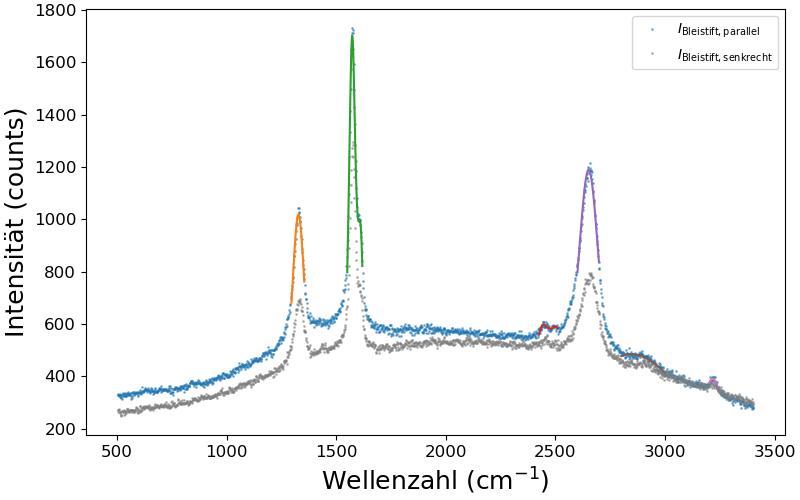

In [28]:
# Shift graphite wavenumber assuming wavenumber shift is constant
df_bleistift_parallel['Wavenumber'] = df_bleistift_parallel['Wavenumber_org'] - wavenumber_shift
df_bleistift_perpendicular['Wavenumber'] = df_bleistift_perpendicular['Wavenumber_org'] - wavenumber_shift
df_graphit_parallel['Wavenumber'] = df_graphit_parallel['Wavenumber_org'] - wavenumber_shift
df_graphit_perpendicular['Wavenumber'] = df_graphit_perpendicular['Wavenumber_org'] - wavenumber_shift



# Fitting Peaks

# Peak 1 1325 1/cm
xdata_bleistift_p1, params_bleistift_p1, params_bleistift_p1_error = n_lorentzians_fit(df_bleistift_parallel, lorentzian, 1296, 1355, p0=None)
print(f'Peak 1 x0 = {params_bleistift_p1[0]:.2f} +- {params_bleistift_p1_error[0]:.2f}')




# Double Peak 2 1569 1/cm and 1609 1/cm
xdata_bleistift_p2, params_bleistift_p2, params_bleistift_p2_error = n_lorentzians_fit(df_bleistift_parallel, double_lorentzian, 1550, 1620,
                                                                              p0=[1574, 10, 1740, 1604, 5, 1005])
print(f'Peak 2 x01 = {params_bleistift_p2[0]:.2f} +- {params_bleistift_p2_error[0]:.2f} and ' +
      f'{params_bleistift_p2[3]:.2f} +- {params_bleistift_p2_error[3]:.2f}')




# double Peak 3 2430 1/cm and 2509 1/cm
xdata_bleistift_p3, params_bleistift_p3, params_bleistift_p3_error = n_lorentzians_fit(df_bleistift_parallel, double_lorentzian, 2425, 2510,
                                                                                       p0=[2449, 10, 610, 2494, 5, 605])
print(f'Peak 3 x01 = {params_bleistift_p3[0]:.2f} +- {params_bleistift_p3_error[0]:.2f} and ' +
     f'{params_bleistift_p3[3]:.2f} +- {params_bleistift_p3_error[3]:.2f}')



# Peak 4 at 2650 1/cm
xdata_bleistift_p4, params_bleistift_p4, params_bleistift_p4_error = n_lorentzians_fit(df_bleistift_parallel, lorentzian, 2600, 2700,
                                                                                       p0 = [2654, 45, 1200])
print(f'Peak 4 x0 = {params_bleistift_p4[0]:.2f} +- {params_bleistift_p4_error[0]:.2f}')



# Peak 5 at 2844 1/cm
xdata_bleistift_p5, params_bleistift_p5, params_bleistift_p5_error = n_lorentzians_fit(df_bleistift_parallel, lorentzian, 2800, 3000,
                                                                                       p0=[2894, 50, 500])
print(f'Peak 5 x0 = {params_bleistift_p5[0]:.2f} +- {params_bleistift_p5_error[0]:.2f}')


# Peak 6 at 


xdata_bleistift_p6, params_bleistift_p6, params_bleistift_p6_error = n_lorentzians_fit(df_bleistift_parallel, lorentzian, 3200, 3250,
                                                                                       p0=[3220, 15, 400])
print(f'Peak 6 x0 = {params_bleistift_p6[0]:.2f} +- {params_bleistift_p6_error[0]:.2f}')








fig, ax = plt.subplots(figsize=(8,5), constrained_layout = True)

# Bleistift parallel
ax.plot(df_bleistift_parallel['Wavenumber'], df_bleistift_parallel['Intensity'], label=r'$\mathit{I}_{Bleistift, parallel}$', ls='',
        marker='o', ms=1, alpha=0.5)
ax.plot(xdata_bleistift_p1, lorentzian(xdata_bleistift_p1, *params_bleistift_p1))
ax.plot(xdata_bleistift_p2, double_lorentzian(xdata_bleistift_p2, *params_bleistift_p2))
ax.plot(xdata_bleistift_p3, double_lorentzian(xdata_bleistift_p3, *params_bleistift_p3))
ax.plot(xdata_bleistift_p4, lorentzian(xdata_bleistift_p4, *params_bleistift_p4))
ax.plot(xdata_bleistift_p5, lorentzian(xdata_bleistift_p5, *params_bleistift_p5))
ax.plot(xdata_bleistift_p6, lorentzian(xdata_bleistift_p6, *params_bleistift_p6))


# Bleistift perpendicular
ax.plot(df_bleistift_perpendicular['Wavenumber'], df_bleistift_perpendicular['Intensity'], label=r'$\mathit{I}_{Bleistift, senkrecht}$', ls='',
        marker='o', ms=1, alpha=0.5)

# Graphit
# ax.plot(df_graphit_parallel['Wavenumber'], df_graphit_parallel['Intensity'], label=r'$\mathit{I}_{Graphit, parallel}$', ls='',
#         marker='o', ms=1)
# ax.plot(df_graphit_perpendicular['Wavenumber'], df_graphit_perpendicular['Intensity'], label=r'$\mathit{I}_{Graphit, senkrecht}$', ls='',
#         marker='o', ms=1)


ax.set_xlabel(r'Wellenzahl ($cm^{-1}$)', fontsize=18)
ax.set_ylabel('Intensität (counts)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend()
